# Predict a numeric/continuous value

## Linear Learner

https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html

# Prepare the Environment

## Upgrade the version of boto3 and sagemaker

In [1]:
%pip install -qU --upgrade boto3
%pip install -qU --upgrade sagemaker

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from time import gmtime, strftime

## Setup your your environment variables

In [3]:
role = get_execution_role()
sess = sagemaker.Session() 
region = sess.boto_session.region_name
bucket = sess.default_bucket()
print("The role is ", role)
print("The session is ", sess)
print("The region is ", region)
print("The bucket is ", bucket)

The role is  arn:aws:iam::740729256087:role/LabRole
The session is  <sagemaker.session.Session object at 0x7f6b0ef5f190>
The region is  us-east-1
The bucket is  sagemaker-us-east-1-740729256087


## We are going to use Linear Learner to make predicitons based on the Boston Housing Dataset

The Boston Housing Dataset
[The Boston Housing Dataset](https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset/data)

The Boston Housing Dataset is a derived from information collected by the U.S. Census Service concerning housing in the area of Boston MA. The following describes the dataset columns:

* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per \$10,000
* PTRATIO - pupil-teacher ratio by town
* B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT - % lower status of the population
* MEDV - Median value of owner-occupied homes in \$1000's

# Prepare and Inspect the Data
## Download the Dataset to Jupyter Notebook and explore the data by opening it and note that the delimiters are spaces and that there are no headings

In [4]:
# Define the headers accordign to the despcription provided

columns = ['CRIM','ZN','INDUS','CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]

# Load the dataset into a DataFrame usign whitespace as the delimiter. Make sure to tell it that the first row is not the header and include the column names we want to use

housing_data=pd.read_csv('housing.csv', delim_whitespace=True, header=None, names=columns)

In [5]:
housing_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [6]:
# Linear learner can read csv but the the first column is assumed to ne the target label so we need to move MEDV to the first column

new_columns = ['MEDV','ZN','INDUS','CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'CRIM']
housing_data=housing_data.reindex(columns=new_columns)
housing_data.head()

,MEDV,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CRIM
0,24.0,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,0.00632
1,21.6,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,0.02731
2,34.7,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,0.02729
3,33.4,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,0.03237
4,36.2,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,0.06905


In [7]:
# Lets check to see if there are any missing values

housing_data.isnull().sum()

MEDV       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
CRIM       0
dtype: int64

In [8]:
# Use describe to get some information about the data

housing_data.describe()

,MEDV,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CRIM
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.532806,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,3.613524
std,9.197104,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,8.601545
min,5.000000,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,0.006320
25%,17.025000,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,0.082045
50%,21.200000,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,0.256510
75%,25.000000,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,3.677083
max,50.000000,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,88.976200


Text(0.5, 1.0, 'Housing prices frequencies')

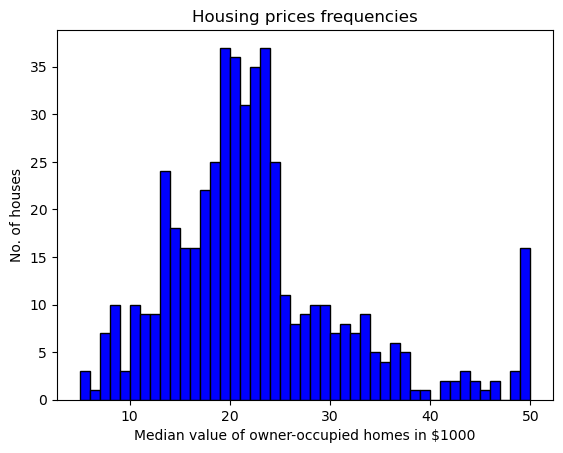

In [9]:
# Use a histogram to see if there are any outliers in the data - here I am only exploring the target values

plt.hist(housing_data['MEDV'], color='blue', edgecolor='black', bins=int(45/1))
plt.xlabel('Median value of owner-occupied homes in $1000')
plt.ylabel('No. of houses')
plt.title('Housing prices frequencies')

## Split the Data into Training and Testing

In [10]:
# Shuffle and Split the data into 80% training and 20% testing

train_data, test_data = train_test_split(housing_data, test_size=0.2)

# Convert dataframes to back to CSV files and save them locally to the notebook and make sure to exclude the headers so taht Linear Learner will accept the file

train_data.to_csv('train.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

In [11]:
# Copy the file to your S3 bucket using sess.upload_data
# You will need to pass the file to be uploaded, a prefix (top level folder to store the data) and the subfolders
# Here we will also define the output folder for the results

prefix = 'housing'
training_data_path = sess.upload_data( path='train.csv', key_prefix=prefix + '/input/train') 
testing_data_path = sess.upload_data( path='test.csv', key_prefix=prefix + '/input/test')
output_data_path = 's3://{}/{}/output'.format(bucket, prefix)
print(training_data_path)
print(testing_data_path)
print(output_data_path)

s3://sagemaker-us-east-1-740729256087/housing/input/train/train.csv
s3://sagemaker-us-east-1-740729256087/housing/input/test/test.csv
s3://sagemaker-us-east-1-740729256087/housing/output


# Train the Model

In [12]:
 # specify containers

from sagemaker.image_uris import retrieve


# List of frameworks that can be retrieved https://sagemaker.readthedocs.io/en/stable/frameworks/index.html
# list of Built-in Algorithms that can be retrieved https://sagemaker.readthedocs.io/en/stable/algorithms/index.html

container = retrieve('linear-learner', region)

In [13]:
# Amazon Estimator Documentation https://sagemaker.readthedocs.io/en/stable/algorithms/sagemaker.amazon.amazon_estimator.html

from sagemaker.estimator import Estimator 
ll_estimator = Estimator(container, 
                         role=role, 
                         instance_count=1, 
                         instance_type='ml.c4.xlarge', 
                         output_path=output_data_path)

In [14]:
# Set the linear learner hyperparameters
# hyperparameters can be found here https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html
# Here we will use the Hyperameter values for 


ll_estimator.set_hyperparameters(predictor_type='regressor')

In [15]:
# Creating a channel from the S3 data source and file system
# TrainingInput documentation https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html

from sagemaker import TrainingInput 
training_data_channel = TrainingInput( s3_data=training_data_path, content_type='text/csv') 
testing_data_channel = TrainingInput( s3_data=testing_data_path,   content_type='text/csv')

## Find the best hyperparameters

In [16]:
# Hyperparameters = https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html
# Objectives = https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner-tuning.html

from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hypertuner = HyperparameterTuner(ll_estimator, 
                                 objective_metric_name = 'test:absolute_loss',
                                 hyperparameter_ranges = {
                                 'learning_rate' : ContinuousParameter(0.01, 0.1),
                                 'mini_batch_size': CategoricalParameter([32,64,128,256,512])},
                                 objective_type = 'Minimize',
                                 metric_definitions = [{'Name': 'test:absolute_loss', 'Regex': 'loss (\S+)'}],
                                 max_jobs=10, 
                                 max_parallel_jobs=1
                                )
    
    
    

In [17]:
hypertuner.fit( {'train': training_data_channel, 'test': testing_data_channel})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


................................................................................................................................!


In [18]:
print("Best hyerparameter tuning job:{}".format(hypertuner.best_training_job()))
print("Best parameters found={}".format(hypertuner.best_estimator().hyperparameters()))

Best hyerparameter tuning job:linear-learner-230202-1604-007-ffec218a

2023-02-02 16:12:52 Starting - Found matching resource for reuse
2023-02-02 16:12:52 Downloading - Downloading input data
2023-02-02 16:12:52 Training - Training image download completed. Training in progress.
2023-02-02 16:12:52 Uploading - Uploading generated training model
2023-02-02 16:12:52 Completed - Resource reused by training job: linear-learner-230202-1604-008-cb0d966c
Best parameters found={'_tuning_objective_metric': 'test:absolute_loss', 'learning_rate': '0.018266315065397474', 'mini_batch_size': '128', 'predictor_type': 'regressor'}


# Train the Model

In [19]:
# Set the linear learner hyperparameters
# hyperparameters can be found here https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html
# We will use the values discovered about for learning_rate and mini_batch_size

ll_estimator.set_hyperparameters(feature_dim=13, # There are 13 feature columns
                                 predictor_type='regressor',
                                 mini_batch_size=128,
                                 learning_rate=0.018266315065397474)

In [20]:
# Now we are going to Fit the model
# Documentaiton for FIT https://sagemaker.readthedocs.io/en/stable/algorithms/sagemaker.amazon.amazon_estimator.html#sagemaker.amazon.amazon_estimator.AmazonAlgorithmEstimatorBase.fit

ll_estimator.fit( {'train': training_data_channel, 'test': testing_data_channel})

INFO:sagemaker:Creating training-job with name: linear-learner-2023-02-02-16-20-19-995


2023-02-02 16:20:20 Starting - Starting the training job...
2023-02-02 16:20:39 Starting - Preparing the instances for training......
2023-02-02 16:21:46 Downloading - Downloading input data...
2023-02-02 16:22:11 Training - Downloading the training image...........Docker entrypoint called with argument(s): train
Running default environment configuration script
[02/02/2023 16:23:59 INFO 140073518991168] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0', 'quantile': '0.5', 'loss_insensitivity': '0.01', 'huber_delt

# Deploy the model
## Here we are going to deploy the model so that we can make some inferences

In [21]:
# Retrieve model data from training job
training_job_model_data = ll_estimator.model_data
training_job_model_data

's3://sagemaker-us-east-1-740729256087/housing/output/linear-learner-2023-02-02-16-20-19-995/output/model.tar.gz'

In [22]:
# Create a unique model name so it won't overwrite ones taht are already there using date and time
deployed_linear_model_name = "boston-housing-deployed-ll-model" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name is " + deployed_linear_model_name)

Model name is boston-housing-deployed-ll-model2023-02-02-16-25-05


In [23]:
# Container Definition https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_ContainerDefinition.html

client = boto3.client(service_name="sagemaker")

create_model_response = client.create_model(
    ModelName=deployed_linear_model_name,
    Containers=[
        {
            "Image": container, # use the same container defined in the estimator
            "ModelDataUrl": training_job_model_data
        }
    ],
    ExecutionRoleArn=role,
)

print("Model Arn: " + create_model_response["ModelArn"])

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Model Arn: arn:aws:sagemaker:us-east-1:740729256087:model/boston-housing-deployed-ll-model2023-02-02-16-25-05


In [24]:
boston_housing_epc_name = "linear-learner-serverless-epc" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=boston_housing_epc_name,
    ProductionVariants=[
        {
            "VariantName": "llVariant",
            "ModelName": deployed_linear_model_name,
            "ServerlessConfig": {
                "MemorySizeInMB": 4096,
                "MaxConcurrency": 1,
            },
        },
    ],
)

print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

Endpoint Configuration Arn: arn:aws:sagemaker:us-east-1:740729256087:endpoint-config/linear-learner-serverless-epc2023-02-02-16-25-06


In [25]:
boston_housing_ep_name = "linear-learner-serverless-ep" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

create_endpoint_response = client.create_endpoint(
    EndpointName=boston_housing_ep_name,
    EndpointConfigName=boston_housing_epc_name,
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-east-1:740729256087:endpoint/linear-learner-serverless-ep2023-02-02-16-25-06


In [26]:
# wait for endpoint to reach a terminal state (InService) using describe endpoint
import time

describe_endpoint_response = client.describe_endpoint(EndpointName=boston_housing_ep_name)

while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = client.describe_endpoint(EndpointName=boston_housing_ep_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)

describe_endpoint_response

Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService


{'EndpointName': 'linear-learner-serverless-ep2023-02-02-16-25-06',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:740729256087:endpoint/linear-learner-serverless-ep2023-02-02-16-25-06',
 'EndpointConfigName': 'linear-learner-serverless-epc2023-02-02-16-25-06',
 'ProductionVariants': [{'VariantName': 'llVariant',
   'DeployedImages': [{'SpecifiedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1',
     'ResolvedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner@sha256:798a5d87639595079ed13ab06a14139de304f673078a2ef11783fa10cc01896f',
     'ResolutionTime': datetime.datetime(2023, 2, 2, 16, 25, 7, 683000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 0,
   'CurrentServerlessConfig': {'MemorySizeInMB': 4096, 'MaxConcurrency': 1}}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 2, 2, 16, 25, 7, 2000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 2, 2, 16, 27

In [27]:
runtime = boto3.client(service_name="sagemaker-runtime")

response = runtime.invoke_endpoint(
    EndpointName=boston_housing_ep_name,
    Body="80.0,1.52,0,0.404,7.274,38.3,7.309,2,329.0,12.6,392.2,6.62,0.03768",
    ContentType="text/csv",
)

print(response["Body"].read())

b'{"predictions": [{"score": 34.345664978027344}]}'


In [28]:
client.delete_model(ModelName=deployed_linear_model_name)
client.delete_endpoint_config(EndpointConfigName=boston_housing_epc_name)
client.delete_endpoint(EndpointName=boston_housing_ep_name)

{'ResponseMetadata': {'RequestId': '4ad33271-97bc-4f30-8d23-a33faa3502cf',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '4ad33271-97bc-4f30-8d23-a33faa3502cf',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 02 Feb 2023 16:27:54 GMT'},
  'RetryAttempts': 0}}